<a href="https://colab.research.google.com/github/hykim-1/Study/blob/main/Alcohol_Sales_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/Alcohol_Sales.csv')

In [2]:
# 타깃 시계열만 뽑기
ts = df['S4248SM144NCEN'].values.reshape(-1,1)

In [3]:
# 2. 정규화
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts)

In [4]:
# 3. 시퀀스(X)와 라벨(y) 만들기
#    window 개(최근 12개월)를 보고 다음달(13번째 값)을 예측
window = 12
X_list, y_list = [], []
for i in range(len(ts_scaled) - window):
    X_list.append(ts_scaled[i:i+window])
    y_list.append(ts_scaled[i+window])
X = np.array(X_list)   # (samples, 12, 1)
y = np.array(y_list)   # (samples, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (313, 12, 1)
y shape: (313, 1)


In [5]:
# 4. train / test 분리
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Train size:", X_train.shape, y_train.shape)
print("Test size :", X_test.shape, y_test.shape)

Train size: (250, 12, 1) (250, 1)
Test size : (63, 12, 1) (63, 1)


In [6]:
# 스케일링 확인
print("scaled y_test first 5:", y_test[:5].flatten())
print("scaled y_test min/max:", y_test.min(), y_test.max())

scaled y_test first 5: [0.64996392 0.77591598 0.44303696 0.48328389 0.56313637]
scaled y_test min/max: 0.430449771506454 1.0


In [7]:
# 5. 모델 A: SimpleRNN 기반
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=(window,1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

model_rnn.compile(optimizer='adam', loss='mse')

history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=0
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# 6. 모델 B: LSTM 기반
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window, 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=0
)

In [9]:
# 7. 예측 (테스트셋에 대해서만 비교)
y_pred_rnn  = model_rnn.predict(X_test)
y_pred_lstm = model_lstm.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


In [10]:
# 8. 역정규화 (원래 단위로 복원)
y_test_inv       = scaler.inverse_transform(y_test)
y_pred_rnn_inv   = scaler.inverse_transform(y_pred_rnn)
y_pred_lstm_inv  = scaler.inverse_transform(y_pred_lstm)

In [11]:
# 9. RMSE 계산 (모델별)
rmse_rnn  = sqrt(mean_squared_error(y_test_inv, y_pred_rnn_inv))
rmse_lstm = sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))

print("RNN  RMSE:", rmse_rnn)
print("LSTM RMSE:", rmse_lstm)

RNN  RMSE: 543.818983621488
LSTM RMSE: 1600.55797047224


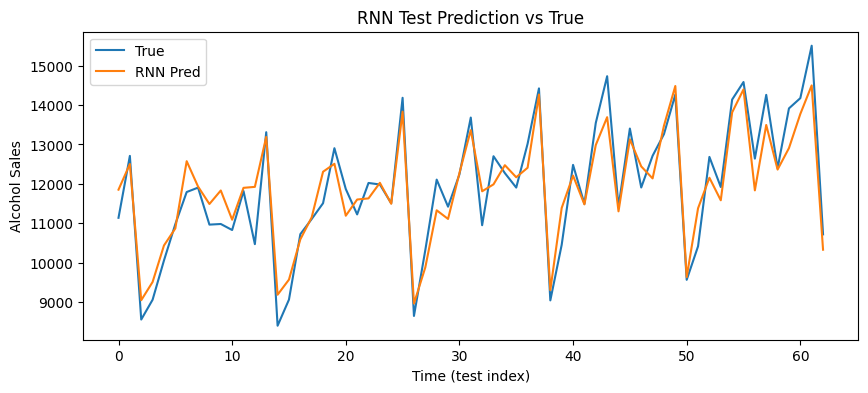

In [12]:
# 10. 그래프 1: RNN 실제 vs 예측
plt.figure(figsize=(10,4))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_rnn_inv, label='RNN Pred')
plt.title('RNN Test Prediction vs True')
plt.xlabel('Time (test index)')
plt.ylabel('Alcohol Sales')
plt.legend()
plt.show()

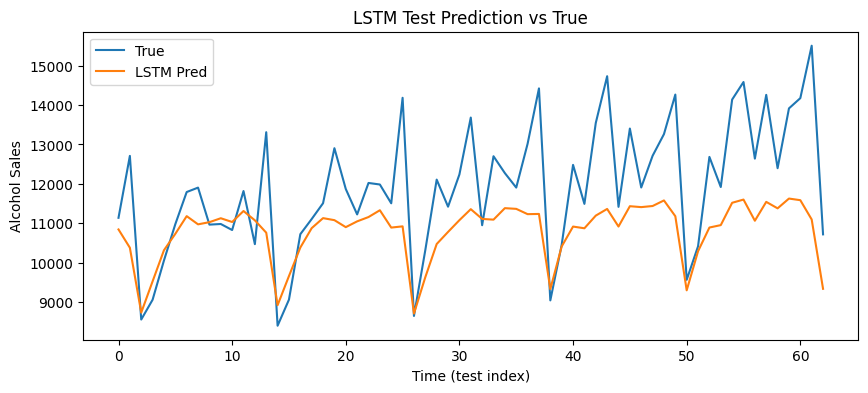

In [13]:
# 11. 그래프 2: LSTM 실제 vs 예측
plt.figure(figsize=(10,4))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_lstm_inv, label='LSTM Pred')
plt.title('LSTM Test Prediction vs True')
plt.xlabel('Time (test index)')
plt.ylabel('Alcohol Sales')
plt.legend()
plt.show()